<a href="https://colab.research.google.com/github/Blaisekhan/Capstone-project/blob/main/Capstone_codes_copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
#Importing Libraries
import numpy as np
import pandas as pd
import math
import json
import time
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings; warnings.simplefilter('ignore')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


In [3]:
#importing the updated dataset Amazon electronics ratings 2018
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Load dataset
ratings_electronics = pd.read_csv('/content/drive/MyDrive/Electronics/Electronics.csv', names=['ProductID', 'UserID','Rating', 'Timestamp'])


## **Exploring the Dataset**

In [5]:
#Snippet of dataset

ratings_electronics.head()


,ProductID,UserID,Rating,Timestamp
0,0060009810,A1N070NS9CJQ2I,5.0,1026864000
1,0060009810,A3P0KRKOBQK1KN,5.0,1025913600
2,0060009810,A192HO2ICJ75VU,5.0,1025654400
3,0060009810,A2T278FKFL3BLT,4.0,1025395200
4,0060009810,A2ZUXVTW8RXBXW,5.0,1025222400


In [6]:
#Data types

ratings_electronics.dtypes

ProductID     object
UserID        object
Rating       float64
Timestamp      int64
dtype: object

In [6]:
#Print data shape in order to determine the subset needed for the analysis
ratings_electronics.shape

(20994353, 4)

In [7]:
#The dataset has 20,994,353 rows and 4 columns 
#Choosing a subset of the data

ratings_electronics = ratings_electronics.iloc[:5000000,0:]

ratings_electronics.shape








(5000000, 4)

In [8]:
#Checking the data to see if there are missing values.
if ratings_electronics is not None:
  print('There are no missing values in the dataset')

There are no missing values in the dataset


In [9]:
#Information about the data

ratings_electronics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   ProductID  object 
 1   UserID     object 
 2   Rating     float64
 3   Timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 152.6+ MB


In [10]:
#Data Statitical summary
ratings_electronics.describe()['Rating']

count    5.000000e+06
mean     4.102528e+00
std      1.346475e+00
min      1.000000e+00
25%      4.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: Rating, dtype: float64

In [11]:
#Checking for min and max ratings

print('Min rate =', ratings_electronics.Rating.min(),  'and max rate =', 
      ratings_electronics.Rating.max(), 'This implies that the rating for the each product \nranges from 0 to 5')

Min rate = 1.0 and max rate = 5.0 This implies that the rating for the each product 
ranges from 0 to 5


In [12]:
#Getting the total number of customers and products reviewed in the data subset 
print("Total number of unique customers and rated products\n","*"*60)
print("Unique users: ", len(np.unique(ratings_electronics.UserID)))
print("Total number of rated products: ", len(np.unique(ratings_electronics.ProductID)))
print("Total number of ratings: ", ratings_electronics.shape[0])

Total number of unique customers and rated products
 ************************************************************
Unique users:  2926618
Total number of rated products:  50935
Total number of ratings:  5000000


2,926,618 customers provided 5 million ratings for 50,935 products

Text(0, 0.5, 'Total Ratings')

Text(0.5, 1.0, 'Ratings distribution')

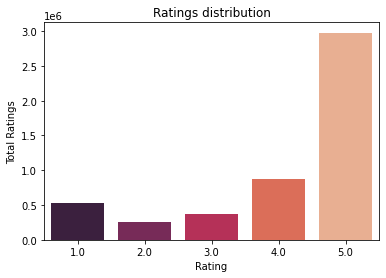

In [44]:
#Display the distribution of customer ratings
ht = sns.countplot(x = 'Rating', data= ratings_electronics, color= 'Purple', palette= 'rocket')
plt.ylabel('Total Ratings')
plt.title("Ratings distribution")
plt.show()

From the distribution above, most customers gave a 5 star rating to electronics on amazon's store. 

In [14]:
user_ratings = ratings_electronics.groupby('ProductID')['UserID'].count().sort_values(ascending = False)

Text(0.5, 1.0, 'Rating Per Product')

Text(0.5, 0, 'Products')

Text(0, 0.5, 'Ratings per product')

[]

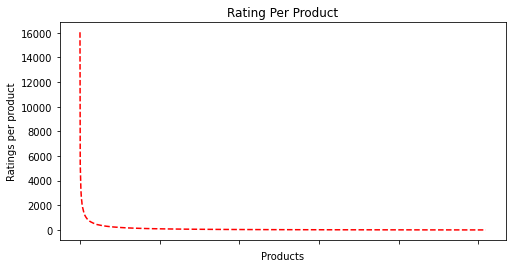

In [50]:
#plotting the rating per product
ratings_per_pdt = ratings_electronics.groupby("ProductID")["Rating"].count().sort_values(ascending=False)


fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot( ratings_per_pdt.values, 'r--')
plt.title("Rating Per Product")
plt.xlabel('Products')
plt.ylabel('Ratings per product')
ax.set_xticklabels([])
plt.show()

UserID
A5JLAU2ARJ0BO     324
A6FIAB28IS79      319
A3OXHLG6DIBRW8    281
A680RUE1FDO8B     248
ADLVFFE4VBT8      220
Name: Rating, dtype: int64

Text(0.5, 1.0, 'Rating Per Product')

Text(0.5, 0, 'Users')

Text(0, 0.5, 'Ratings per product')

[]

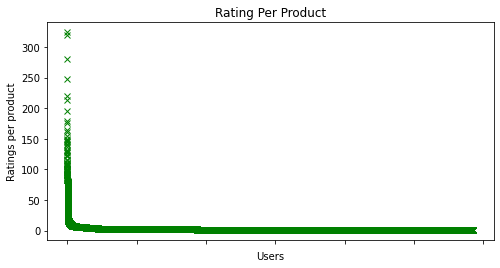

In [51]:
#Determing the number of ratings provided by each user

rates_per_user=ratings_electronics.groupby(by='UserID')['Rating'].count().sort_values(ascending=False)
rates_per_user.head()

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(rates_per_user.values, 'gx')
plt.title("Rating Per Product")
plt.xlabel('Users')
plt.ylabel('Ratings per product')
ax.set_xticklabels([])

plt.show()


From the data subset that is going to be used in building the recommendation system, the most ratings provided by one customer is 324.

In [17]:
#Dropping columns not needed in the analysis 
del ratings_electronics['Timestamp']


Dropped the Timestamp column as it won't be needed in building a model-based collaborative filtering recommendation. Timestamps are useful in building Time-Sensitive collaborative filtering models in recommender systems (L. Sun, E. I. Michael, S. Wang and Y. Li, "A Time-Sensitive Collaborative Filtering Model in Recommendation Systems," 2016 IEEE International Conference on Internet of Things (iThings) and IEEE Green Computing and Communications (GreenCom) and IEEE Cyber, Physical and Social Computing (CPSCom) and IEEE Smart Data (SmartData), Chengdu, China, 2016, pp. 340-344, doi: 10.1109/iThings-GreenCom-CPSCom-SmartData.2016.81.)

In [18]:
ratings_electronics.head()

,ProductID,UserID,Rating
0,0060009810,A1N070NS9CJQ2I,5.0
1,0060009810,A3P0KRKOBQK1KN,5.0
2,0060009810,A192HO2ICJ75VU,5.0
3,0060009810,A2T278FKFL3BLT,4.0
4,0060009810,A2ZUXVTW8RXBXW,5.0


From the data subset that is going to be used in building the recommendation system, the most ratings provided by one customer is 324.

In [19]:
ratings_electronics.shape

(5000000, 3)

## **Popularity-Based Recommendation(Simple Recommender)**

This system utilizes the popularity characteristics of products as popularity of a product greatly influences consumer purchasing decisions and often represents important characteristics of a product.
This system works best for businesses that are focused on marketing goods and services that are in trend. 

A commonly known major setback with this method is that, it can't be personalized. 

In [20]:
#Downsizing dataframe to only contain products that received 50 ratings and above
most_rates = ratings_electronics.groupby("ProductID").filter(lambda x:x["Rating"].count()>=50)


Downsized the dataframe to only contain products that received 50 ratings and above. 

In [21]:
most_rates.head()
most_rates.shape

,ProductID,UserID,Rating
284,0511189877,A3J3BRHTDRFJ2G,2.0
285,0511189877,A1QGNMC6O1VW39,5.0
286,0511189877,A2TY0BTJOTENPG,5.0
287,0511189877,A34ATBPOK6HCHY,5.0
288,0511189877,A89DO69P0XZ27,5.0


(4471445, 3)

In [22]:
#Save Dataframe to drive
most_rates.to_csv('/content/drive/MyDrive/Electronics/Over_50_rates.csv')

In [23]:
#Number of ratings received by each product
ratings_per_pdt = most_rates.groupby("ProductID")["Rating"].count()
ratings_per_pdt.head()

ProductID
0101635370     68
0511189877    105
0545105668     52
0594033926     82
0594459451    124
Name: Rating, dtype: int64

In [24]:
#Average product rating 

avg_rate_per_pdt = most_rates.groupby('ProductID')['Rating'].mean()
avg_rate_per_pdt.head()

ProductID
0101635370    2.985294
0511189877    4.266667
0545105668    4.692308
0594033926    4.634146
0594459451    4.540323
Name: Rating, dtype: float64

To determine the final rating of a product, add all the ratings users gave that product and divide by the total ratings received by the product to get the average 

In [48]:
#Getting the products with the highest Average rating 

most_rates.groupby('ProductID')['Rating'].mean().sort_values(ascending = False).head(10)

ProductID
1630460001    5.000000
B00180IWA6    5.000000
B000SL2AQI    5.000000
B003BLVOE6    5.000000
B00008VSKS    5.000000
B003L1AINY    5.000000
B001F21XIK    5.000000
B000HARV82    5.000000
B00000J0MS    4.997494
B000TMFYBO    4.963636
Name: Rating, dtype: float64

Products B000HARV82 and B00008VSKS got 5 stars from all customers that rated the product. This is a good indicator for the seller to put more of these products on their shelves or website. 5 star rating is a good feedback from customers indicating either their satisfaction or how valuable they found the product or service. 

In [51]:
#Total number of ratings received by each product

most_rates.groupby('ProductID')['Rating'].count().sort_values(ascending=False).head(10)

ProductID
B003L1ZYYW    16046
B0019HL8Q8    15389
B0019EHU8G    14133
B0015DYMVO    13836
B000BQ7GW8    13768
B0043T7FXE    13024
B000VS4HDM    10708
B0043WJRRS    10685
B0013FRNKG    10212
B003MTTJOY    10186
Name: Rating, dtype: int64

Product B003L1ZYYW received 16046 ratings which is the most ratings received by a single product.

In [25]:
#Creating a new Dataframe that contains the ProductID, 
#Average rating(Rating) and total rating(Ratings_count) received by each product

avg_total_rating = pd.DataFrame(most_rates.groupby('ProductID')['Rating'].mean())

In [26]:
avg_total_rating['Ratings_Count'] = pd.DataFrame(most_rates.groupby('ProductID')['Rating'].count())

In [27]:

avg_total_rating.head()

,Rating,Ratings_Count
ProductID,,
0101635370,2.985294,68
0511189877,4.266667,105
0545105668,4.692308,52
0594033926,4.634146,82
0594459451,4.540323,124


In [65]:
avg_total_rating['Ratings_Count'].sort_values(ascending = False).head()

ProductID
B003L1ZYYW    16046
B0019HL8Q8    15389
B0019EHU8G    14133
B0015DYMVO    13836
B000BQ7GW8    13768
              ...  
B000LVKNN2       50
B001VKYAKO       50
B004X18N24       50
B0016HW2CA       50
B000087HWM       50
Name: Ratings_Count, Length: 15497, dtype: int64

In [28]:
avg_total_rating.shape

(15497, 2)

Text(0.5, 1.0, 'Average Rating Distribution')

(array([  14.,   28.,   83.,  241.,  626., 1331., 2676., 4250., 4819.,
        1429.]),
 array([1.26470588, 1.63823529, 2.01176471, 2.38529412, 2.75882353,
        3.13235294, 3.50588235, 3.87941176, 4.25294118, 4.62647059,
        5.        ]),
 <a list of 10 Patch objects>)

Text(0.5, 0, 'Average_Rating')

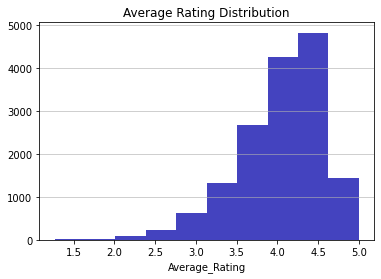

In [41]:

plt.title('Average Rating Distribution')
plt.hist(avg_total_rating['Rating'], color='#0504aa', alpha=0.75)
plt.xlabel('Average_Rating')
plt.grid(axis= 'y', alpha=0.75)
plt.show()

Most of the products which received 50 ratings and above had an average rating of between 4.3 and 4.5

<Figure size 1440x3600 with 0 Axes>

Text(0.5, 0.98, 'Ratings VS Ratings_Received')

Text(0.5, 0.98, 'Ratings VS Ratings_Received')

<Figure size 1440x3600 with 0 Axes>

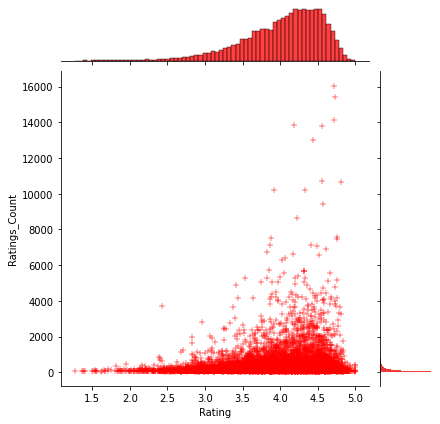

In [63]:
#Ratings Vs Ratings received 
plt.figure(figsize=(20,50))
fig.suptitle('Ratings VS Ratings_Received')
sns.jointplot(x='Rating', y='Ratings_Count', data= avg_total_rating, alpha=1, color='r', marker = '+')
fig.suptitle('Ratings VS Ratings_Received')

From the figure above, the products with ratings between 4.3 to 4.5 received the most reviews from buyers. The amount of reviews given begins to drop as the rating moves closer to 5 stars. 
In all fairness, the ratings for the products that received less reviews would have been better if they received a proportionate amount of reviews as the products the received the most ratings. Also, the poor ratings that they received my have deterred customers away from buying the products. For example, comparing the rating of a product that has 2 starts from 3 reviews to one that 4 stars from 500 ratings won't be fair. 

Text(0, 0.5, 'Ratings received')

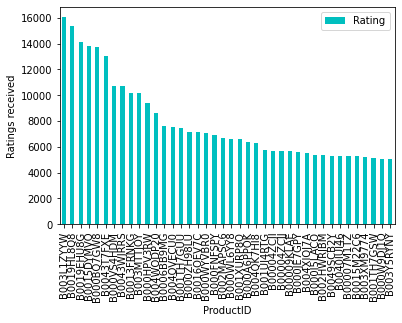

In [84]:
#Popular products based on total number of ratings provided by customers 

pop_pdts = pd.DataFrame(most_rates.groupby('ProductID')['Rating'].count())
most_pop = pop_pdts.sort_values('Rating', ascending = False)
most_pop.head(40).plot(kind='bar', color='c')
plt.ylabel('Ratings received')



The plot above shows the top 40 popular electronics on Amazon's online store based on the number of rating provided by customers. These products would be the first to be recommended to a customer browsing through the electronics section on Amazon's website because of their popularity.  

# **Model-Based Collaborative Filtering**

Using machine learning to train models to make predictions 



In [ ]:
pip install scikit-surprise

     |████████████████████████████████| 11.8MB 6.1MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617589 sha256=c90fbc3064783b5baf04b64bfefbf73ae5deb87e4f68c27cb6d95d3a77e6e261
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [ ]:
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import os
from surprise.model_selection import train_test_split


In [ ]:
#Downsizing dataframe to only contain products that received 50 ratings and above
most_rates = ratings_electronics.groupby("ProductID").filter(lambda x:x["Rating"].count()>=50)

In [ ]:
e_rating = ratings_electronics.head(1000000)

In [ ]:
e_rating.shape

(1000000, 3)

In [ ]:
e_rating.head()

,ProductID,UserID,Rating
0,0060009810,A1N070NS9CJQ2I,5.0
1,0060009810,A3P0KRKOBQK1KN,5.0
2,0060009810,A192HO2ICJ75VU,5.0
3,0060009810,A2T278FKFL3BLT,4.0
4,0060009810,A2ZUXVTW8RXBXW,5.0


Splitting the data into Test and train sets


In [ ]:
#reading the dataset
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(e_rating[['UserID','ProductID', 'Rating']],reader)

In [ ]:

trainset, testset = train_test_split(data, test_size = .20)

**Building the recommender engine with Single Value Decompostion (SVD)**


In [ ]:
#Implimenting SVD 
model = SVD()

#fitting the model
model.fit(trainset)

In [ ]:
#Making predictions and checking for accuracy
predictions = model.test(testset)

accuracy.rmse(predictions)

RMSE: 1.2186


1.2185743809793677

In [ ]:
#Assign any user_id and item_id to uid and iid respectively to predict the rating the user(uid) would give the item(iid)
uid = 'A2ZUXVTW8RXBXW'
iid = '0060009810'

In [ ]:
pred = model.predict(uid, iid)

In [ ]:

pred.est

4.341957976104355

According to the prediction estimate, User A2ZUXVTW8RXBXW would give item 0060009810 a 4.3 star rating 